# Laboratorio 2: Detección de Spam
### Universidad del Valle de Guatemala
### Integrantes:
##### Oliver de León 19270
##### Julio Herrera 19402
##### Diego Arredondo 19422

In [42]:
#Importar las librerías
import pandas as pd
import numpy as np
import nltk
import unidecode
import contractions
import unicodedata
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Parte 1: Ingeniería de características

### Exploración de Datos

In [43]:
## Cargar el dataset proporcionado
ds1 = pd.read_csv('./Datasets/completeSpamAssassin.csv')
ds2 = pd.read_csv('./Datasets/enronSpamSubset.csv')

print('-------D-A-T-A-S-E-T--1-------\n', ds1.head(), '\n-------------------------------------\n')
print('-------D-A-T-A-S-E-T--2-------\n', ds2.head(), '\n-------------------------------------')



-------D-A-T-A-S-E-T--1-------
    Unnamed: 0                                               Body  Label
0           0  \r\nSave up to 70% on Life Insurance.\r\nWhy S...      1
1           1  1) Fight The Risk of Cancer!\r\nhttp://www.adc...      1
2           2  1) Fight The Risk of Cancer!\r\nhttp://www.adc...      1
3           3  ##############################################...      1
4           4  I thought you might like these:\r\n1) Slim Dow...      1 
-------------------------------------

-------D-A-T-A-S-E-T--2-------
    Unnamed: 0.1  Unnamed: 0  \
0          2469        2469   
1          5063        5063   
2         12564       12564   
3          2796        2796   
4          1468        1468   

                                                Body  Label  
0  Subject: stock promo mover : cwtd\r\n * * * ur...      1  
1  Subject: are you listed in major search engine...      1  
2  Subject: important information thu , 30 jun 20...      1  
3  Subject: = ? utf - 8 ? q ?

In [44]:
# Unificación de tablas

# Limpieza dataset 1, se quita la columna 'Unnamed: 0'
columns = list(ds1)
columns.pop(0)
ds1 = ds1[columns]

# Limpieza dataset 2, se quitan las columnas 'Unnamed: 0.1' y 'Unnamed: 0'
columns = list([0,1])
ds2.drop(ds2.columns[[i for i in columns]], axis=1, inplace=True)

print('-------D-A-T-A-S-E-T--1-------\n', ds1.head(), '\n-------------------------------------\n')
print('-------D-A-T-A-S-E-T--2-------\n', ds2.head(), '\n-------------------------------------\n')

# Concatenación de datasets
df = pd.concat([ds1, ds2])
df = df.reset_index(drop=True)
print('-------D-A-T-A-S-E-T--F-I-N-A-L-------\n', df.head(), '\n-------------------------------------')


-------D-A-T-A-S-E-T--1-------
                                                 Body  Label
0  \r\nSave up to 70% on Life Insurance.\r\nWhy S...      1
1  1) Fight The Risk of Cancer!\r\nhttp://www.adc...      1
2  1) Fight The Risk of Cancer!\r\nhttp://www.adc...      1
3  ##############################################...      1
4  I thought you might like these:\r\n1) Slim Dow...      1 
-------------------------------------

-------D-A-T-A-S-E-T--2-------
                                                 Body  Label
0  Subject: stock promo mover : cwtd\r\n * * * ur...      1
1  Subject: are you listed in major search engine...      1
2  Subject: important information thu , 30 jun 20...      1
3  Subject: = ? utf - 8 ? q ? bask your life with...      1
4  Subject: " bidstogo " is places to go , things...      1 
-------------------------------------

-------D-A-T-A-S-E-T--F-I-N-A-L-------
                                                 Body  Label
0  \r\nSave up to 70% on Life Insura

### Preprocesamiento

In [45]:
'''
param text: lista de palabras
Remueve signos de puntuación y caracteres especiales
return: nueva lista de palabras
'''
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

'''
param text: lista de palabras
Remueve palabras que no son ASCII
return: nueva lista de palabras
'''
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

'''
param text: lista de palabras
Pasa todas las palabras a minúsculas
return: nueva lista de palabras
'''
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

'''
param text: lista de palabras
Remueve stop words
return: nueva lista de palabras
'''
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

'''
param text: lista de palabras
Aplica stemming a las palabras
return: nueva lista de palabras
'''
def stem_words(words):
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

'''
param text: lista de palabras
Aplica lemmatization a las palabras
return: nueva lista de palabras
'''
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

'''
param text: Texto a preprocesar
Aplica cambio a minúsculas, remueve acentos, tokeniza el texto en palabras y elimina stop words
Si el texto no es de tipo str, float o int, retorna None
return: Texto preprocesado
'''
def preprocessing(text):
    
    # Convierte todo a str
    if type(text) in [float, int]:
        text = str(text)
    elif type(text) != str:
        return None
    
    # Todo en minúsculas
    text = text.lower()

    # Remueve acentos
    text = unidecode.unidecode(text)

    # Expande contracciones
    text = contractions.fix(text)
    
    # Tokeniza el texto en palabras
    words = word_tokenize(text)

    # Aplica normalización a las palabras
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)

    filtered_text = " ".join(words)
    
    return filtered_text

In [46]:
# Aplicación de las funciones construídas

df['Body'] = df['Body'].apply(preprocessing)

# Guardar el dataset preprocesado en un archivo csv
df.to_csv('./Datasets/text_filtered.csv', index=False)
print(df.sample(n=5).head())

                                                    Body  Label
15794  subject ardmor facil follow meet last week col...      0
13661  subject pregunta pregunta question spanish go ...      0
7334   subject cds billig wie noch nie seid ihr auf d...      1
12435  subject hl p get chanc would like go alloc day...      0
10287  subject sp erm pi lls multiopl org asm men lnc...      1


### Representación de Texto

### Modelo Bag of Words

In [47]:
dBoW = pd.read_csv('./Datasets/text_filtered.csv')
dBoW.fillna('', inplace=True)
dBoW = dBoW['Body'].to_list()
# print 3 samples
print(dBoW[0], '\n')
print(dBoW[1], '\n')
print(dBoW[2])

save 70 life insur spend life quot save ensur famili financi secur import life quot save make buy life insur simpl afford provid free access best compani lowest rateslif quot save fast easi save money let us help get start best valu countri new coverag save hundr even thousand dollar request free quot lifequot save servic take less 5 minut complet shop compar save 70 type life insur click free quot protect famili best invest ever make receipt email error andor wish remov list pleas click type remov resid state prohibit email solicit insur pleas disregard email 

1 fight risk cancer http wwwadclickwspcfm o315 spk0072 slim guarante lose 1012 lbs 30 day http wwwadclickwspcfm o249 spk0073 get child support deserv free legal advic http wwwadclickwspcfm o245 spk0024 join web fastest grow singl communiti http wwwadclickwspcfm o259 spk0075 start privat photo album onlin http wwwadclickwspcfm o283 spk007have wonder day offer manag prizemamaif wish leav list pleas use link http wwwqvescomtrim il

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0.05, max_df=0.8, ngram_range=(1,2))
# Min_df y Max_df nos sirven para controlar el porcentaje mínimo y máximo de apariciones de un token
cv_matrix = cv.fit_transform(dBoW)
cv_matrix = cv_matrix.toarray()
cv_matrix = cv_matrix.astype(np.int32)
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Ejemplo de mensajes en representacion numerica con BoG (Bag of Words) con ngramas de tamaño 1 y 2

In [49]:
# Palabras únicas del corpus
vocabulario = cv.get_feature_names_out()
# Mostrar el vector
pd.DataFrame(cv_matrix, columns=vocabulario)

,00,000,01,02,10,100,11,12,15,18,...,wish,within,without,work,world,would,would like,write,www,year
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16041,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16042,5,0,6,1,5,0,1,1,9,1,...,0,0,0,0,0,0,0,0,0,0
16043,0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
16044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modelo Bag of N - grams

In [50]:
bv = CountVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.8)
bv_matrix = bv.fit_transform(dBoW)

bv_matrix = bv_matrix.toarray()
vocabulario = bv.get_feature_names_out()
pd.DataFrame(bv_matrix, columns=vocabulario)

,00,000,01,02,10,100,11,12,15,18,...,wish,within,without,work,world,would,would like,write,www,year
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16041,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16042,5,0,6,1,5,0,1,1,9,1,...,0,0,0,0,0,0,0,0,0,0
16043,0,0,0,1,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
16044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0.05, max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(dBoW)
tv_matrix = tv_matrix.toarray()

vocabulario = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocabulario)

,00,000,01,02,10,100,11,12,15,18,...,well,wish,within,without,work,world,would,write,www,year
0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.09,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
1,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.17,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
2,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.20,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
3,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.06,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.05
4,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.20,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16041,0.00,0.0,0.00,0.00,0.47,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
16042,0.09,0.0,0.11,0.02,0.07,0.0,0.02,0.02,0.16,0.02,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
16043,0.00,0.0,0.00,0.03,0.02,0.0,0.00,0.00,0.00,0.03,...,0.0,0.00,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.00
16044,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00


# Parte 2: Implementación de un clasificador de spam

## Modelo Naive Bayes
Naive Bayes es muy usado para la clasificación de texto, ya que asume que la presencia de una palabra en una clase no está relacionada con la presencia de otra palabra.

### Separación de datos

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

XBoN = cv_matrix
XTFIDF = tv_matrix
Y = df['Label'].to_numpy() # TO-DO: no tener que quitar los últimos 4 a mano

# Datos de entrenamiento 70% y datos de prueba 30%
x_train_BoN, x_test_BoN, y_train_BoN, y_test_BoN = train_test_split(XBoN, Y, test_size=0.3, random_state=42)
x_train_TFIDF, x_test_TFIDF, y_train_TFIDF, y_test_TFIDF = train_test_split(XTFIDF, Y, test_size=0.3, random_state=42)

### Entrenamiento del modelo, un modelos por cada modelo de representación de texto

In [53]:
modelBoW = MultinomialNB()
BoWClass = modelBoW.fit(x_train_BoN, y_train_BoN)
modelTFIDF = MultinomialNB()
TFIDFClass = modelTFIDF.fit(x_train_TFIDF, y_train_TFIDF)

### Predicción

In [54]:
BoNPred = BoWClass.predict(x_test_BoN)
TFIDFPred = TFIDFClass.predict(x_test_TFIDF)

### Matriz de confusión

Matriz de confusión para el modelo de Bag of Words

Accuracy Score 0.8714167012879103
Confusion Matrix
 [[2398  330]
 [ 289 1797]]


<AxesSubplot:>

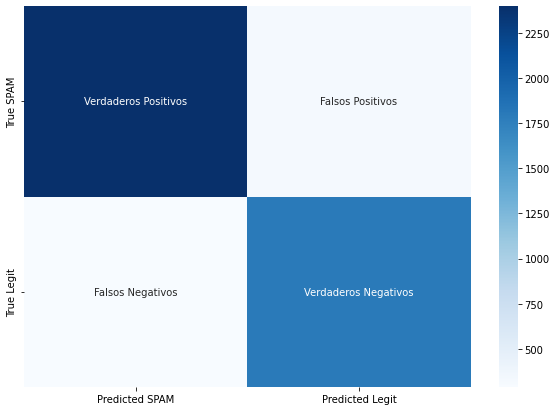

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

matrix_BoN = confusion_matrix(y_test_BoN, BoNPred)
labels = ["Verdaderos Positivos","Falsos Positivos","Falsos Negativos","Verdaderos Negativos"]
labels = np.asarray(labels).reshape(2,2)
df_cm = pd.DataFrame(matrix_BoN, index = ['True SPAM','True Legit'],
                    columns = ['Predicted SPAM','Predicted Legit'])
print('Accuracy Score', accuracy_score(y_test_BoN, BoNPred))
print('Confusion Matrix\n', confusion_matrix(y_test_BoN, BoNPred))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=labels, fmt="", cmap='Blues')

Matriz de confusión para el modelo de Bag of N-grams

Accuracy Score 0.8955130868300789
Confusion Matrix
 [[2569  159]
 [ 344 1742]]


<AxesSubplot:>

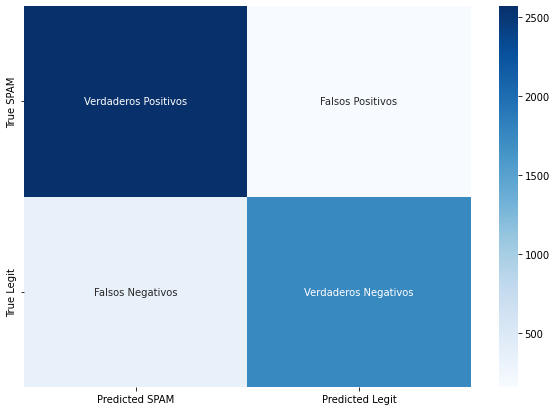

In [56]:
matrix_TFIDF = confusion_matrix(y_test_TFIDF, TFIDFPred)
labels = ["Verdaderos Positivos","Falsos Positivos","Falsos Negativos","Verdaderos Negativos"]
labels = np.asarray(labels).reshape(2,2)
df_cm = pd.DataFrame(matrix_TFIDF, index = ['True SPAM','True Legit'],
                    columns = ['Predicted SPAM','Predicted Legit'])
print('Accuracy Score', accuracy_score(y_test_TFIDF, TFIDFPred))
print('Confusion Matrix\n', confusion_matrix(y_test_TFIDF, TFIDFPred))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=labels, fmt="", cmap='Blues')

### Interpretación de la matriz de confusión:
En la matriz de confusión los Verdaderos positivos se refiere a los correos que fueron clasificados como spam y que realmente lo son, los falsos positivos son los correos que fueron clasificados como legítimos y que realmente son spam, los falsos negativos son los correos que fueron clasificados como spam y que realmente son legítimos y los verdaderos negativos son los correos que fueron clasificados como legítimos y que realmente lo son.

En un clasificador de correos se prefiere que los falsos positivos sean bajos, ya que si se clasifican como legítimos correos que son spam, estos pueden llegar a la bandeja de entrada del usuario y este puede perder tiempo revisando correos que no son importantes o caer en un correo malicioso. Para conocer mejor el rendimiento sobre los falsos positivos se puede calcular la precisión, que es la relación entre los verdaderos positivos y la suma de los verdaderos positivos y los falsos positivos.

### Métricas de evaluación
 - Precision: Es la relación entre los verdaderos positivos y la suma de los verdaderos positivos y los falsos positivos.
 - Recall: Es la relación entre los verdaderos positivos y la suma de los verdaderos positivos y los falsos negativos.
 - F1 Score: Es la media armónica entre la precisión y el recall.

Metricas para el modelo de Bag of Words

In [57]:
print(classification_report(y_test_BoN, BoNPred, target_names=['legit', 'spam']))

              precision    recall  f1-score   support

       legit       0.89      0.88      0.89      2728
        spam       0.84      0.86      0.85      2086

    accuracy                           0.87      4814
   macro avg       0.87      0.87      0.87      4814
weighted avg       0.87      0.87      0.87      4814



Metricas para el modelo de Bag of N-grams

In [58]:
print(classification_report(y_test_TFIDF, TFIDFPred, target_names=['legit', 'spam']))

              precision    recall  f1-score   support

       legit       0.88      0.94      0.91      2728
        spam       0.92      0.84      0.87      2086

    accuracy                           0.90      4814
   macro avg       0.90      0.89      0.89      4814
weighted avg       0.90      0.90      0.89      4814



Tanto en la matriz de confusión como en las métricas de evaluación se puede observar que el modelo de TF-IDF tiene un mejor rendimiento que el modelo de Bag of Words, en cuanto a la precisión el modelo de TF-IDF tuvo un 0.92 sobre la clase de SPAM la cual es la que nos importa y el modelo Bag of Words tuvo un 0.84. En un overall tomando en cuenta el F1 Score el modelo de TF-IDF tuvo un 0.90 y el modelo Bag of Words tuvo un 0.87. Por lo que se puede concluir que el modelo de TF-IDF es mejor que el modelo Bag of Words, esto puede ser ya que el modelo de TF-IDF tiene en cuenta la frecuencia de las palabras en el documento y en el corpus, mientras que el modelo Bag of Words solo tiene en cuenta la frecuencia de las palabras en el documento.